## Task Description

In this notebook, we will implement a custom Extended Long Short-Term Memory (xLSTM) model to predict the next tokens given an input sequence. The Model is described in the paper [xLSTM: Extended Long Short-Term Memory](https://arxiv.org/abs/2405.04517).

We will work with the “Tiny Shakespeare” dataset, a character-level corpus of Shakespeare’s plays and sonnets, commonly used for next-character prediction. The dataset is available at [Github](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt).

We will implement a custom character‐level tokenizer and DataLoader, write our custom Model (with different classes) and train it, plot the Perplexity score and the loss curve and finally showcase input–output text samples from our trained xLSTM.

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import math

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# Configuration
## Checkpointing
RESUME_FROM_CHECKPOINT = False
SAVE_EVERY_N_BATCHES = 1000

### Google Drive Setup for Checkpointing

In [3]:
# Mount Google Drive for checkpoint saving
from google.colab import drive
import os
from datetime import datetime

# Mount Google Drive
drive.mount('/content/drive')

# Create checkpoint directory
checkpoint_dir = '/content/drive/MyDrive/xlstm_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

print(f"Google Drive mounted successfully!")
print(f"Checkpoint directory: {checkpoint_dir}")

Mounted at /content/drive
Google Drive mounted successfully!
Checkpoint directory: /content/drive/MyDrive/xlstm_checkpoints


### **Preparing the Tokenizer and Dataloader** (1 point)

In [4]:
# Character-level tokenizer
class CharTokenizer:
    def __init__(self, text):
        self.chars = sorted(set(text))
        self.char_to_idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(self.chars)}
        self.vocab_size = len(self.chars)

    def encode(self, text):
        return [self.char_to_idx[ch] for ch in text]

    def decode(self, indices):
        return ''.join([self.idx_to_char[i] for i in indices])

# Dataset class
class ShakespeareDataset(Dataset):
    def __init__(self, text, tokenizer, seq_length):
        self.tokenizer = tokenizer
        self.seq_length = seq_length
        self.data = tokenizer.encode(text)

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx+self.seq_length], dtype=torch.long)
        y = torch.tensor(self.data[idx+1:idx+self.seq_length+1], dtype=torch.long)
        return x, y

# Load and prepare data
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

tokenizer = CharTokenizer(text)
seq_length = 64
dataset = ShakespeareDataset(text, tokenizer, seq_length)

# Split into train and validation
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"Dataset size: {len(dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Vocabulary size: 65
Dataset size: 1115330
Training samples: 1003797
Validation samples: 111533


### **Preparing the Model** (2.5 point)

#### components

In [5]:
class BlockDiagonalProj(nn.Module):
    def __init__(self, input_dim, num_heads):
        super(BlockDiagonalProj, self).__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.out_head_size = input_dim // num_heads
        self.weight = nn.Parameter(torch.empty(num_heads, self.out_head_size, input_dim // num_heads))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x):
        shape = x.shape
        x = x.view(*shape[:-1], self.num_heads, -1)
        x = torch.einsum("...hd,hod->...ho", x, self.weight)
        x = x.reshape(*shape[:-1], -1)
        return x

class CausalConv1d(nn.Module):
    def __init__(self, feature_dim, kernel_size, bias=True):
        super(CausalConv1d, self).__init__()
        self.pad = (kernel_size -1)
        self.conv = nn.Conv1d(in_channels=feature_dim, out_channels=feature_dim, kernel_size=kernel_size, padding=self.pad, groups=feature_dim, bias=bias)
    def forward(self, x):
        y = x.transpose(2, 1)
        y = self.conv(y)
        return y[:, :, : -self.pad].transpose(2, 1)


#### mLSTM block

In [ ]:
class mLSTMCell(nn.Module):
    def __init__(self, input_dim, num_heads):
        super(mLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads

        self.i_proj = BlockDiagonalProj(input_dim, num_heads)
        self.f_proj = BlockDiagonalProj(input_dim, num_heads)
        self.o_proj = BlockDiagonalProj(input_dim, num_heads)

    def forward(self, q, k, v, x_conv):
        B, S, _ = q.shape

        # Reshape to heads
        q = q.view(B, S, self.num_heads, self.head_dim)
        k = k.view(B, S, self.num_heads, self.head_dim)
        v = v.view(B, S, self.num_heads, self.head_dim)

        # Get gates from conv output
        i_tild = self.i_proj(x_conv).view(B, S, self.num_heads, self.head_dim)
        f_tild = self.f_proj(x_conv).view(B, S, self.num_heads, self.head_dim)
        o_tild = self.o_proj(x_conv).view(B, S, self.num_heads, self.head_dim)

        # Apply activations (for i and f we use the stabilisation as in the paper first)
        o = torch.sigmoid(o_tild)

        # Initialize states
        C = torch.zeros(B, self.num_heads, self.head_dim, self.head_dim, device=q.device)
        n = torch.zeros(B, self.num_heads, self.head_dim, device=q.device)
        m_prev = torch.zeros(B, self.num_heads, self.head_dim, device=q.device)

        outputs = []

        for t in range(S):
            qt = q[:, t]  # [B, H, D]
            kt = k[:, t]  # [B, H, D]
            vt = v[:, t]  # [B, H, D]
            i_tild_t = i_tild[:, t]  # [B, H, D]
            f_tild_t = f_tild[:, t]  # [B, H, D]
            ot = o[:, t]  # [B, H, D]

            m_new = torch.maximum(f_tild_t + m_prev, i_tild_t)
            it = torch.exp(i_tild_t - m_new)                   # stabil. input gate
            ft = torch.exp(f_tild_t + m_prev - m_new)          # stabil. forget gate
            m_prev = m_new

            vk_outer = torch.einsum('bhd,bhe->bhde', vt, kt)  # [B, H, D, D]

            # Expand gates for matrix operations
            ft_matrix = ft.unsqueeze(-1)  # [B, H, D, 1]
            it_matrix = it.unsqueeze(-1)  # [B, H, D, 1]

            C = ft_matrix * C + it_matrix * vk_outer
            n = ft * n + it * kt

            # Compute normalizer term
            n_dot_q = torch.einsum('bhd,bhd->bh', n, qt)    # [B, H]
            n_term = torch.maximum(torch.abs(n_dot_q), torch.ones_like(n_dot_q))

            h_tilde = torch.einsum('bhde,bhe->bhd', C, qt)  # [B, H, D]
            h_tilde_norm = h_tilde / n_term.unsqueeze(-1)   # [B, H, D]
            h_t = ot * h_tilde_norm                         # [B, H, D]

            outputs.append(h_t)

        # Stack outputs
        output = torch.stack(outputs, dim=1)  # [B, S, H, D]
        output = output.transpose(1, 2)       # [B, H, S, D]

        return output

class mLSTMLayer(nn.Module):
    def __init__(self, embedding_dim, proj_blocksize, bias=False):
        super(mLSTMLayer, self).__init__()
        self.outer_embedding_dim = embedding_dim
        self.inner_embedding_dim = 2 * embedding_dim
        self.proj_blocksize = proj_blocksize
        self.bias = bias

        self.proj_up = nn.Linear(in_features=self.outer_embedding_dim,
                                 out_features= 2 * self.inner_embedding_dim,
                                 bias=bias)
        self.num_proj_heads = self.inner_embedding_dim // proj_blocksize
        self.q_proj = BlockDiagonalProj(input_dim=self.inner_embedding_dim, num_heads=self.num_proj_heads)
        self.k_proj = BlockDiagonalProj(input_dim=self.inner_embedding_dim, num_heads=self.num_proj_heads)
        self.v_proj = BlockDiagonalProj(input_dim=self.inner_embedding_dim, num_heads=self.num_proj_heads)

        self.conv1d = CausalConv1d(feature_dim=self.inner_embedding_dim, kernel_size=4)
        self.conv_swish = nn.SiLU()

        self.mlstm_cell = mLSTMCell(self.inner_embedding_dim, self.num_proj_heads)

        self.ogate_swish = nn.SiLU()
        self.learnable_skip_con = nn.Parameter(torch.ones(self.inner_embedding_dim, requires_grad=True))
        self.proj_down = nn.Linear(in_features=self.inner_embedding_dim,
                                 out_features=self.outer_embedding_dim,
                                 bias=bias)



    def forward(self, x):
        B, S, _ = x.shape
        x_ = F.layer_norm(x, normalized_shape=(self.outer_embedding_dim,))
        x_inner = self.proj_up(x_)
        x_mlstm, z = torch.split(x_inner, split_size_or_sections=self.inner_embedding_dim, dim=-1)
        x_mlstm_conv = self.conv1d(x_mlstm)
        x_mlstm_conv_act = self.conv_swish(x_mlstm_conv)

        q = self.q_proj(x_mlstm_conv_act)
        k = (1.0 / math.sqrt(self.num_proj_heads)) * self.k_proj(x_mlstm_conv_act)
        v = self.v_proj(x_mlstm)

        y_ = self.mlstm_cell(q, k, v, x_mlstm_conv_act)

        B_, NH_, S_, DH_ = y_.shape
        gn_in_1 = y_.transpose(1, 2)  # [B, S, NH, DH]
        gn_in_2 = gn_in_1.reshape(B_ * S_, NH_ * DH_)  # [B*S, NH*DH]
        gn_out = F.group_norm(gn_in_2, num_groups=NH_)
        out = gn_out.view(B, S, -1)

        mlstm_cell_skip = out + (self.learnable_skip_con * x_mlstm_conv_act)

        h_state = mlstm_cell_skip * self.ogate_swish(z)

        y = self.proj_down(h_state) + x

        return y


#### sLSTM block

In [ ]:
class sLSTMCell(nn.Module):
    def __init__(self, input_dim, num_heads):
        super(sLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads

    def forward(self, i_tild, f_tild, z_tild, o_tild):
        B, S, D = i_tild.shape

        # Apply activations
        # Note: we use m_t to calculate i'_t and f'_t instead of i_t and f_t
        z = torch.tanh(z_tild)
        o = torch.sigmoid(o_tild)

        # Reshape to heads
        i_tild = i_tild.view(B, S, self.num_heads, self.head_dim)
        f_tild = f_tild.view(B, S, self.num_heads, self.head_dim)
        z = z.view(B, S, self.num_heads, self.head_dim)
        o = o.view(B, S, self.num_heads, self.head_dim)

        # Initialize states
        c = torch.zeros(B, self.num_heads, self.head_dim, device=i_tild.device)
        n = torch.zeros(B, self.num_heads, self.head_dim, device=i_tild.device)
        m_prev = torch.zeros(B, self.num_heads, self.head_dim, device=i_tild.device)

        outputs = []

        # Process sequence
        for t in range(S):
            f_tild_t = f_tild[:, t]  # [B, H, D]
            i_tild_t = i_tild[:, t]  # [B, H, D]
            z_t = z[:, t]
            o_t = o[:, t]

            m_new = torch.maximum(f_tild_t + m_prev, i_tild_t)
            i_t = torch.exp(i_tild_t - m_new) # stabil. input gate
            f_t = torch.exp(f_tild_t + m_prev - m_new) # stabil. forget gate
            m_prev = m_new

            c = f_t * c + i_t * z_t
            n = f_t * n + i_t

            h_tild = c / n
            h = o_t * h_tild

            outputs.append(h)

        # Stack outputs and reshape properly
        output = torch.stack(outputs, dim=1)  # [B, S, H, D]
        output = output.transpose(1,2)        # [B, H, S, D]

        return output

class sLSTMLayer(nn.Module):
    def __init__(self, embedding_dim, proj_blocksize, conv_block=True, bias=False):
        super(sLSTMLayer, self).__init__()
        self.inner_embedding_dim = embedding_dim
        self.proj_blocksize = proj_blocksize
        self.conv_block = conv_block
        self.num_heads = 4

        if conv_block:
            self.conv1d = CausalConv1d(feature_dim=self.inner_embedding_dim, kernel_size=4)
            self.conv_swish = nn.SiLU()

        self.i_proj = BlockDiagonalProj(input_dim=self.inner_embedding_dim, num_heads=self.num_heads)
        self.f_proj = BlockDiagonalProj(input_dim=self.inner_embedding_dim, num_heads=self.num_heads)
        self.z_proj = BlockDiagonalProj(input_dim=self.inner_embedding_dim, num_heads=self.num_heads)
        self.o_proj = BlockDiagonalProj(input_dim=self.inner_embedding_dim, num_heads=self.num_heads)

        self.slstm_cell = sLSTMCell(self.inner_embedding_dim, self.num_heads)

        self.up_proj1 = nn.Linear(in_features=self.inner_embedding_dim, out_features= int((4/3)*self.inner_embedding_dim), bias=bias)
        self.up_proj2 = nn.Linear(in_features=self.inner_embedding_dim, out_features= int((4/3)*self.inner_embedding_dim), bias=bias)
        self.up_proj2_gelu = nn.GELU()

        self.down_proj = nn.Linear(in_features=int((4/3)*self.inner_embedding_dim), out_features=self.inner_embedding_dim, bias=bias)

    def forward(self, x):
        B, S, _ = x.shape

        x_ = F.layer_norm(x, normalized_shape=(self.inner_embedding_dim,))

        if self.conv_block:
            x_conv = self.conv1d(x_)
            x_conv_act = self.conv_swish(x_conv)
        else:
            x_conv_act = x_
        i = self.i_proj(x_conv_act)
        f = self.f_proj(x_conv_act)
        z = self.z_proj(x_)
        o = self.o_proj(x_)

        y_ = self.slstm_cell(i, f, z, o)

        B_, NH_, S_, DH_ = y_.shape
        gn_in_1 = y_.transpose(1, 2)
        gn_in_2 = gn_in_1.reshape(B_ * S_, NH_ * DH_)
        gn_out = F.group_norm(gn_in_2, num_groups=NH_)
        out = gn_out.view(B, S, -1)

        skip_con = x + out
        skip_con_layer_norm = F.layer_norm(skip_con, normalized_shape=(self.inner_embedding_dim,))

        up_proj1 = self.up_proj1(skip_con_layer_norm)
        up_proj2 = self.up_proj2(skip_con_layer_norm)
        up_proj2_act = self.up_proj2_gelu(up_proj2)
        down_proj = self.down_proj(up_proj2_act * up_proj1)
        y = down_proj + skip_con
        return y

xLSTM

In [8]:
class xLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, num_layers=4, proj_blocksize=32):
        super(xLSTM, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        nn.init.normal_(self.embedding.weight, mean=0.0, std=0.02)

        # xLSTM layers with 1:1 ratio (TODO: 7:1 is best according to paper)
        self.layers = nn.ModuleList([
            nn.ModuleDict({
                "sLSTM": sLSTMLayer(embedding_dim, proj_blocksize),
                "mLSTM": mLSTMLayer(embedding_dim, proj_blocksize)
            }) for _ in range(num_layers)
        ])

        # Output layer
        self.output_layer = nn.Linear(embedding_dim, vocab_size)
        nn.init.normal_(self.output_layer.weight, mean=0.0, std=0.02)

    def forward(self, x):
        # Embedding
        x = self.embedding(x)  # [B, S, D]

        # Pass through xLSTM layers
        for layer_dict in self.layers:
            # Apply sLSTM then mLSTM
            x = layer_dict["sLSTM"](x)
            x = layer_dict["mLSTM"](x)

        # Output projection
        output = self.output_layer(x)  # [B, S, vocab_size]

        return output

### Checkpoint Management Functions

In [9]:
import glob

def save_checkpoint(model, optimizer, epoch, losses, perplexities, checkpoint_dir):
    """Save model checkpoint to Google Drive"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    checkpoint_path = os.path.join(checkpoint_dir, f'xlstm_checkpoint_epoch_{epoch+1}_{timestamp}.pt')

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': losses,
        'train_perplexities': perplexities,
        'vocab_size': tokenizer.vocab_size,
        'model_config': {
            'embedding_dim': model.embedding_dim,
            'vocab_size': model.vocab_size
        }
    }

    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")
    return checkpoint_path

def load_checkpoint(checkpoint_path, model, optimizer):
    """Load model checkpoint from Google Drive"""
    checkpoint = torch.load(checkpoint_path, map_location=device)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return (checkpoint['epoch'],
            checkpoint['train_losses'],
            checkpoint['train_perplexities'])

def cleanup_old_checkpoints(checkpoint_dir, keep_last_n=3):
    """Keep only the N most recent checkpoints"""
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, 'xlstm_checkpoint_*.pt'))
    if len(checkpoint_files) > keep_last_n:
        # Sort by modification time (newest first)
        checkpoint_files.sort(key=os.path.getmtime, reverse=True)
        # Remove older checkpoints
        for old_checkpoint in checkpoint_files[keep_last_n:]:
            os.remove(old_checkpoint)
            print(f"Removed old checkpoint: {old_checkpoint}")

def find_latest_checkpoint(checkpoint_dir):
    """Find the most recent checkpoint"""
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, 'xlstm_checkpoint_*.pt'))
    if checkpoint_files:
        return max(checkpoint_files, key=os.path.getmtime)
    return None

print("Checkpoint functions loaded successfully!")

Checkpoint functions loaded successfully!


In [10]:
def create_warmup_cosine_scheduler(optimizer, learning_rate, warmup_batches, total_batches):
    """Create scheduler with linear warmup followed by cosine decay"""
    from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR

    # Linear warmup from 0.1 to 1.0 of base LR
    warmup_scheduler = LinearLR(
        optimizer,
        start_factor=0.1,
        end_factor=1.0,
        total_iters=warmup_batches
    )

    # Cosine annealing from peak to 10% of base LR
    cosine_scheduler = CosineAnnealingLR(
        optimizer,
        T_max=total_batches - warmup_batches,
        eta_min=learning_rate * 0.1
    )

    # Combine schedulers
    scheduler = SequentialLR(
        optimizer,
        schedulers=[warmup_scheduler, cosine_scheduler],
        milestones=[warmup_batches]
    )

    return scheduler

def calculate_perplexity(loss):
    return math.exp(loss)

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)

            # Reshape for loss calculation
            outputs = outputs.view(-1, tokenizer.vocab_size)
            y = y.view(-1)

            loss = criterion(outputs, y)
            total_loss += loss.item()
            num_batches += 1

    return total_loss / num_batches

### **Train the Model** (1 point)

In [ ]:
# Initialize model
model = xLSTM(vocab_size=tokenizer.vocab_size, embedding_dim=128, num_layers=2, proj_blocksize=32)
model = model.to(device)
model = torch.compile(model)

In [12]:
# Training parameters
learning_rate = 1e-4
num_epochs = 2
warmup_batches = 4000
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = create_warmup_cosine_scheduler(optimizer, learning_rate, warmup_batches, num_epochs*len(train_loader))
current_lr = scheduler.get_last_lr()[0]

losses = []
perplexities = []

# Resume from checkpoint if requested
start_epoch = 0
if RESUME_FROM_CHECKPOINT:
    latest_checkpoint = find_latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        print(f"Resuming from checkpoint: {latest_checkpoint}")
        start_epoch, losses, perplexities = load_checkpoint(latest_checkpoint, model, optimizer)
        start_epoch += 1  # Start from next epoch
        print(f"Resuming training from epoch {start_epoch + 1}")
    else:
        print("No checkpoint found, starting fresh training")

torch.set_float32_matmul_precision('high')

print("Starting training...")
for epoch in range(start_epoch, start_epoch + num_epochs):
    model.train()

    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        # Forward pass
        with torch.autocast(device_type="cuda"):
            outputs = model(x)
            loss = criterion(outputs.view(-1, tokenizer.vocab_size), y.view(-1))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Record metrics
        batch_loss = loss.item()
        batch_perplexity = calculate_perplexity(batch_loss)
        losses.append(batch_loss)
        perplexities.append(batch_perplexity)

        # Log to console
        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch {epoch+1}/{start_epoch + num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {batch_loss:.4f}, Perplexity: {batch_perplexity:.4f}, LR: {current_lr:.6f}')

        # Save checkpoint
        if (batch_idx + 1) % SAVE_EVERY_N_BATCHES == 0:
            checkpoint_path = save_checkpoint(
                model, optimizer, epoch, losses, perplexities, checkpoint_dir
            )
            # Clean up old checkpoints
            cleanup_old_checkpoints(checkpoint_dir, keep_last_n=3)

        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]

    print(f'Finished epoch {epoch+1}')

print(f"Training completed!")

Starting training...
Epoch 1/2, Batch 100/7843, Loss: 3.8785, Perplexity: 48.3497, LR: 0.000012
Epoch 1/2, Batch 200/7843, Loss: 3.4580, Perplexity: 31.7537, LR: 0.000014
Epoch 1/2, Batch 300/7843, Loss: 3.3105, Perplexity: 27.3979, LR: 0.000017
Epoch 1/2, Batch 400/7843, Loss: 3.2648, Perplexity: 26.1752, LR: 0.000019
Epoch 1/2, Batch 500/7843, Loss: 3.0672, Perplexity: 21.4814, LR: 0.000021
Epoch 1/2, Batch 600/7843, Loss: 2.8134, Perplexity: 16.6665, LR: 0.000023
Epoch 1/2, Batch 700/7843, Loss: 2.5822, Perplexity: 13.2256, LR: 0.000026
Epoch 1/2, Batch 800/7843, Loss: 2.4694, Perplexity: 11.8159, LR: 0.000028
Epoch 1/2, Batch 900/7843, Loss: 2.3978, Perplexity: 10.9988, LR: 0.000030
Epoch 1/2, Batch 1000/7843, Loss: 2.3417, Perplexity: 10.3990, LR: 0.000032
Checkpoint saved: /content/drive/MyDrive/xlstm_checkpoints/xlstm_checkpoint_epoch_1_20250608_205406.pt
Removed old checkpoint: /content/drive/MyDrive/xlstm_checkpoints/xlstm_checkpoint_epoch_1_20250608_203508.pt
Epoch 1/2, Batch

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/2, Batch 4100/7843, Loss: 1.6705, Perplexity: 5.3149, LR: 0.000100
Epoch 1/2, Batch 4200/7843, Loss: 1.6289, Perplexity: 5.0981, LR: 0.000100
Epoch 1/2, Batch 4300/7843, Loss: 1.6126, Perplexity: 5.0159, LR: 0.000100
Epoch 1/2, Batch 4400/7843, Loss: 1.6320, Perplexity: 5.1143, LR: 0.000100
Epoch 1/2, Batch 4500/7843, Loss: 1.5532, Perplexity: 4.7267, LR: 0.000100
Epoch 1/2, Batch 4600/7843, Loss: 1.6296, Perplexity: 5.1018, LR: 0.000099
Epoch 1/2, Batch 4700/7843, Loss: 1.6192, Perplexity: 5.0493, LR: 0.000099
Epoch 1/2, Batch 4800/7843, Loss: 1.6096, Perplexity: 5.0008, LR: 0.000099
Epoch 1/2, Batch 4900/7843, Loss: 1.5609, Perplexity: 4.7633, LR: 0.000099
Epoch 1/2, Batch 5000/7843, Loss: 1.6007, Perplexity: 4.9564, LR: 0.000098
Checkpoint saved: /content/drive/MyDrive/xlstm_checkpoints/xlstm_checkpoint_epoch_1_20250608_212612.pt
Removed old checkpoint: /content/drive/MyDrive/xlstm_checkpoints/xlstm_checkpoint_epoch_1_20250608_210214.pt
Epoch 1/2, Batch 5100/7843, Loss: 1.58

### **Showcasing plots and few input & output examples** (0.5 point)

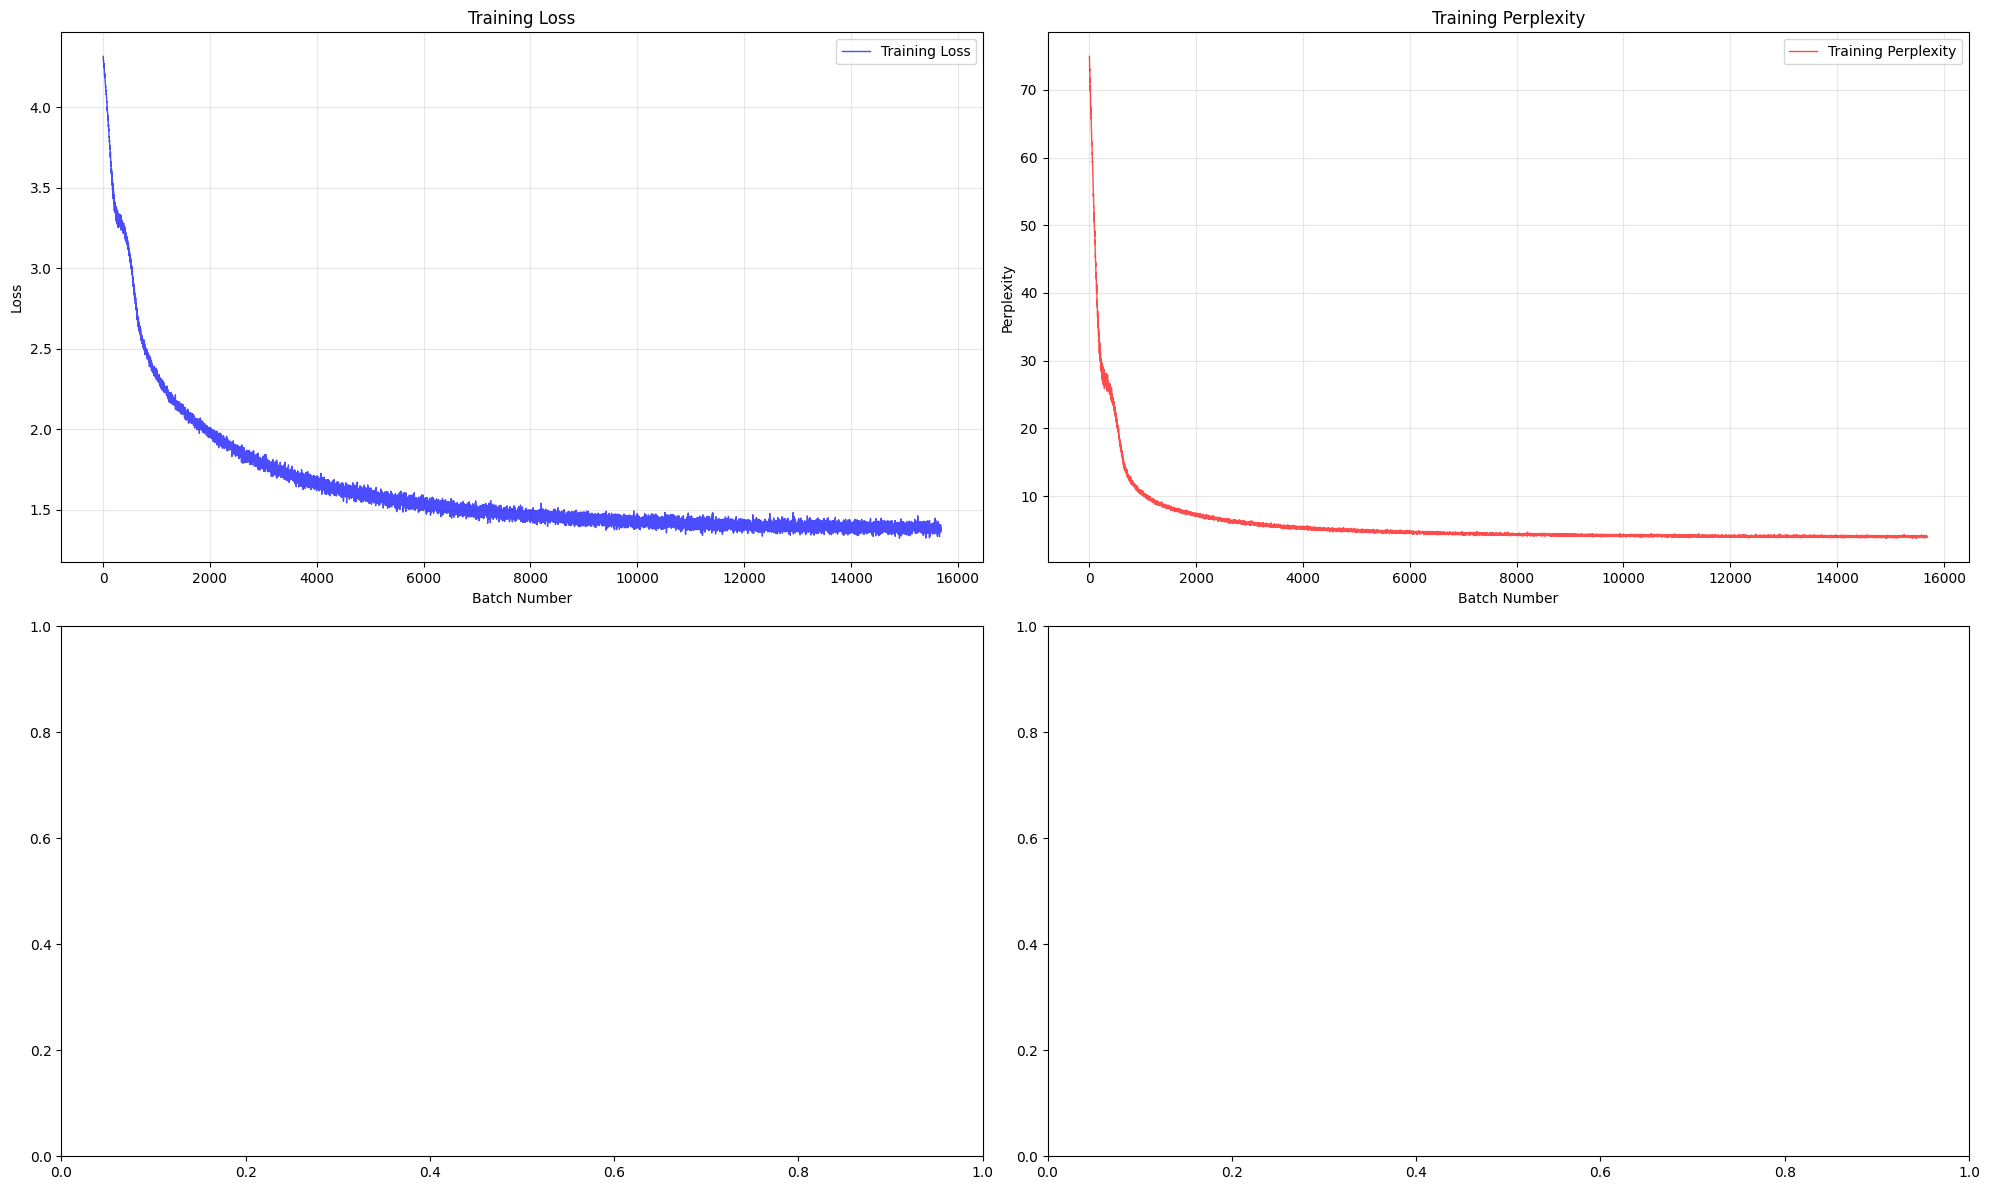

=== Text Generation Examples ===

Example 1:
Prompt: 'ROMEO:'
Generated: ROMEO:
Good getterring, that yet every life devise
Him here and shame unearding of thy reliant
His princely oaths widows in the party been
And thank you tit
--------------------------------------------------------------------------------

Example 2:
Prompt: 'To be or not to be,'
Generated: To be or not to be,
To move the belike with a traitor and the very
And seems my last not, that is justice
To me apple of a word affer are all with thee.

Provost:
Where 
--------------------------------------------------------------------------------

Example 3:
Prompt: 'HAMLET:'
Generated: HAMLET:
For you consure in the causely son,
And heaven my comfort. Thou hast tutken for
the cattering of
Tabitien of his charge that thou should not,
And I w
--------------------------------------------------------------------------------

Example 4:
Prompt: 'Fair is foul and'
Generated: Fair is foul and could trips,
And both the heart. Whom 

In [13]:
# Plot training curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# Plot loss curves
if losses:
    ax1.plot(range(len(losses)), losses, 'b-', alpha=0.7, linewidth=1, label='Training Loss')
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Batch Number')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

# Plot perplexity curves
if perplexities:
    ax2.plot(range(len(perplexities)), perplexities, 'r-', alpha=0.7, linewidth=1, label='Training Perplexity')
    ax2.set_title('Training Perplexity')
    ax2.set_xlabel('Batch Number')
    ax2.set_ylabel('Perplexity')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

def generate_text(model, tokenizer, prompt, max_length=200, temperature=1.0):
    model.eval()

    # Encode the prompt
    tokens = tokenizer.encode(prompt)
    input_ids = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)

    generated = []

    with torch.no_grad():
        for _ in range(max_length):
            # Get model predictions
            outputs = model(input_ids)

            # Get the last token's logits
            next_token_logits = outputs[0, -1, :] / temperature

            # Sample from the distribution
            probs = F.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            # Add the new token to the sequence
            generated.append(next_token.item())
            input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=1)

            # Keep only the last seq_length tokens to avoid memory issues
            if input_ids.size(1) > seq_length:
                input_ids = input_ids[:, -seq_length:]

    # Decode the generated text
    generated_text = tokenizer.decode(generated)
    return prompt + generated_text

# Generate some example texts
print("=== Text Generation Examples ===\n")

prompts = [
    "ROMEO:",
    "To be or not to be,",
    "HAMLET:",
    "Fair is foul and"
]

for i, prompt in enumerate(prompts, 1):
    print(f"Example {i}:")
    print(f"Prompt: '{prompt}'")
    generated = generate_text(model, tokenizer, prompt, max_length=150, temperature=0.8)
    print(f"Generated: {generated}")
    print("-" * 80)
    print()

print("=== Training Summary ===")
if losses:
    print(f"Final Training Loss: {losses[-1]:.4f}")
    print(f"Final Training Perplexity: {perplexities[-1]:.4f}")
print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Vocabulary Size: {tokenizer.vocab_size}")
print(f"Sequence Length: {seq_length}")
print(f"Number of Training Samples: {len(train_dataset)}")
print(f"Number of Validation Samples: {len(val_dataset)}")
if losses:
    print(f"Total Batches Trained: {len(losses)}")